# NLP 2026
# Lab 4: More BERT


In this lab, you will continue working with encoder-only pre-trained model. You will peak inside the model's internal representations and test the models on the task of Natural Language Inference. In general, the task is to decide if two sentences have the same meaning, contradict each other or are neutral. We will simplify this task and only include the positive and negative labels (excluding the neutral label). Effectively, we will approach this as a binary classification task, and you will experiment with the same methods as the last time — from classic machine learning to modern neural networks based on transformers 🚀

### 🎯 Learning Goals ###

By completing this lab, you should be able to:

- Formulate natural language infeernce as a binary classification problem

- Implement a classic representation: Bag-of-Words or Word2Vec

- Apply and evaluate Logistic Regression and alternative classifiers

- Understand how BERT represents tokens internally

- Extract sentences representations using: ```CLS``` token, mean token pooling

- Compare classical ML and transformer-based methods

- Critically analyze evaluation metrics beyond accuracy 📊

### Score breakdown

| Exercise            |
|---------------------|
| [Exercise 1](#e1)   |
| [Exercise 2](#e2)   |
| [Exercise 3](#e3)   |
| [Exercise 4](#e4)   |
| [Exercise 5](#e5)   |
| [Exercise 6](#e6)   |
| [Exercise 7](#e7)   |
| [Exercise 8](#e8)   |
| [Exercise 9](#e9)   |
| [Exercise 10](#e10) |


This score will be scaled down to 0.6 and that will be your final lab score.

### 📌 **Instructions for Delivery** (📅 **Deadline: X/Feb 18:00**, 🎭 *wildcards possible*)

✅ **Submission Requirements**
+ 📄 You need to submit a **report** 📓 in pdf containing your findings. You have to use the template provided alongside this notebook. Note that the report should not exceed 4 pages (we will stop reading after that). Here is the rough structure you will be graded on:
    + Analysis of the contextual embeddings of BERT:
        + Token-level,
        + Sentence-level,
    + Description of the methods you used,
    + Description of the experiments you performed including the dataset and the metrics,
    + Results you obtained,
    + Discussion:
        + Compare the models in terms of metrics,
        + Judge performance,
        + Is it expected? Think about the architecture of the models.
        + How would you expand the experiments in terms of future work?
+ 📄 You also need to submit a **notebook** 📓 with the code, appropriate comments and figures in all questions. Make sure to have a mix of code (some explanations needed if not clear what you implement), figures to support the answers or your claims and proper amount of text to explain your reasoning, answer etc.
    + ⚡ Make sure that **all cells are executed properly** ⚙️ and that **all figures/results/plots** 📊 you include in the report are also visible in your **executed notebook**.
    + You can work on Google Collab (or other environments), but you need to make sure that your delivered notebook is executed properly.

✅ **Collaboration & Integrity**
+ 🗣️ While you may **discuss** the lab with others, you must **write your solutions with your group only**. If you **discuss specific tasks** with others, please **include their names** below.
+ 📜 **Honor Code applies** to this lab. For more details, check **Syllabus §7.2** ⚖️.
+ 📢 **Mandatory Disclosure**:
   - Any **websites** 🌐 (e.g., **Stack Overflow** 💡) or **other resources** used must be **listed and disclosed**.
   - Any **GenAI tools** 🤖 (e.g., **ChatGPT**) used must be **explicitly mentioned**.
   - 🚨 **Failure to disclose these resources is a violation of academic integrity**. See **Syllabus §7.3** for details.

## 0. Setup

We will be using the same libraries as in the previous lab, so here we assume that you have them installed already. Refer to the previous notebook if you need help installing them.
Here are some resources:

* [Scikit-learn](https://scikit-learn.org/stable/),
* [PyTorch](https://pytorch.org/docs/stable/index.html),
* [Hugging Face Transformers](https://huggingface.co/docs/transformers/en/index).


Here, we import the libraries:

In [1]:
import re
from collections import Counter
from typing import List
from itertools import combinations

import datasets
import numpy as np
import torch
import tqdm
import transformers
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt

## Analyzing BERT embeddings

Contrary to the static word embeddings (such as word2vec), where words are assigned to fixed values, BERT takes the context into account. You have seen this in the lecture, some words are ambiguous on their own. BERT (and other Transformer models) achieves it by processing the initial word embeddings through the sequence of layers. Each layer can access information in other tokens in the sequence through the mechanism of attention. Intuitively, the contextualization of embeddings should increase after each layer. In this section, you will see if this is the case.

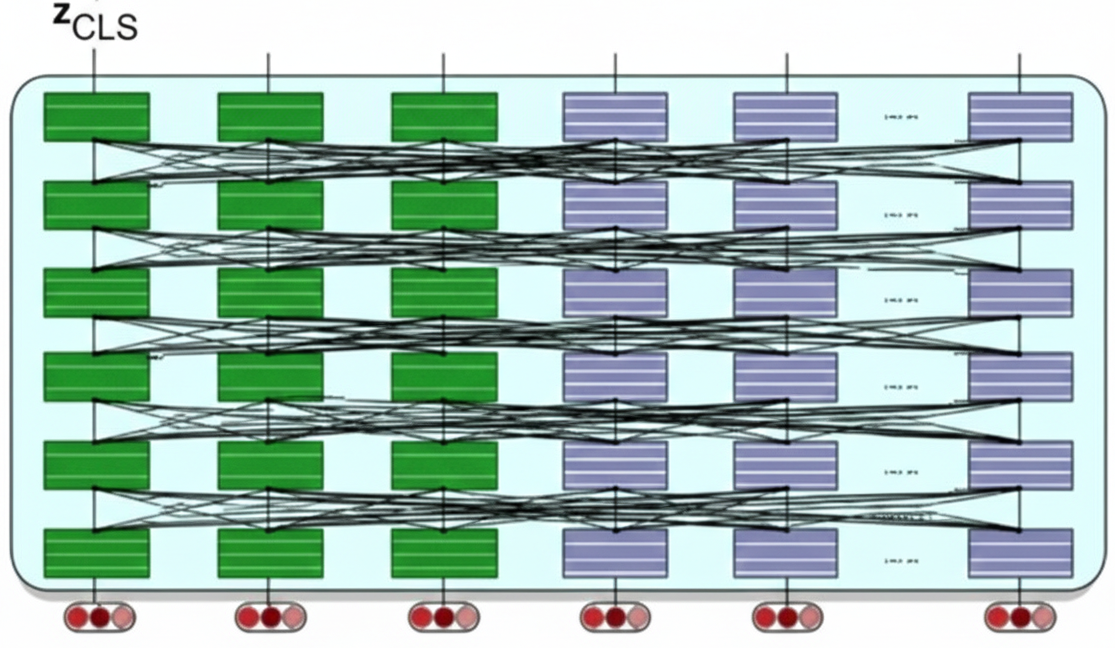

As in the previous lab, we will be using a pre-trained BERT model from Huggingface [BERT Uncased](https://huggingface.co/google-bert/bert-base-uncased).

In [3]:
model_name = 'google-bert/bert-base-uncased'

### Loading the model

We will load the tokenizer and the model in the next cells.

In [4]:
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
print(tokenizer)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

BertTokenizer(name_or_path='google-bert/bert-base-uncased', vocab_size=30522, model_max_length=512, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)


In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

model = transformers.AutoModel.from_pretrained(model_name)
model.to(device)
print(model)

Device: cpu


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: google-bert/bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

### Exploring BERT's hidden states

In this section we will look in more detail into the embeddings (hidden representations) of BERT model. As discussed before, BERT updates the representations of each token by processing them layer by layer. You can view this as updating the residual stream (which was discussed in the lecture). In the previous lab, we were interested only in the final representation (the output of the last layer). But how does the model transform the initial embedding to arrive to the final representation? This is the question we will try to shed some light on. In general, it is very difficult to analyze the raw embeddings, as they high-dimensional vectors. We will, instead, look at how the similarity of words in different contexts changes through the layers. The general idea is to input different sentences to BERT and extract hidden representations (hidden states) to analyze the cosine similarity between specific tokens.

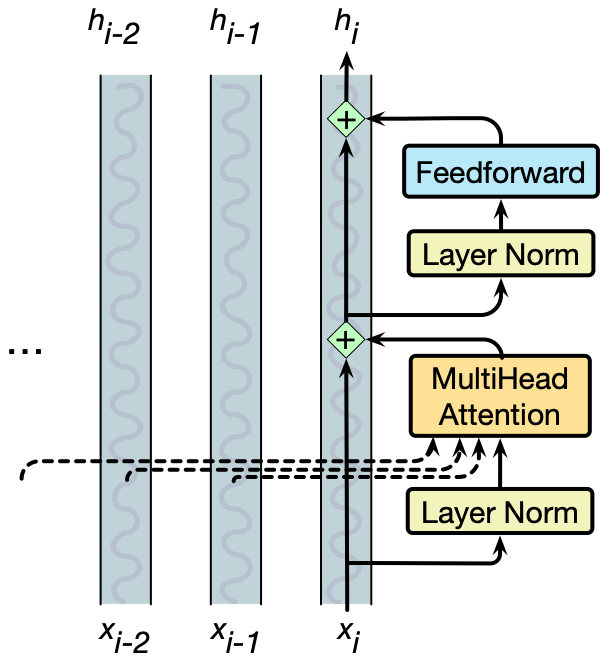

We will use the following function to plot the cosine similarity between tokens in different sentences. Examine the code and make sure it makes sense to you.

In [6]:
def plot_evolving_similarities(hidden_states: List[torch.Tensor], tokens_of_interest_ids: List[int]):
    """
        Plots the cosine similarity between the tokens of interest in different sentences across the layers of the model.
        Tokens of interest are defined in the `tokens_of_interest_ids` parameter.
        The function will plot the cosine similarity between the tokens of interest in different sentences across the layers of the model.
    :param hidden_states:
    :param tokens_of_interest_ids:
    :return:
    """

    assert hidden_states[0].shape[0] == len(tokens_of_interest_ids), \
        'The batch size of hidden_states must be equal to the number of tokens of interest'

    num_layers = len(hidden_states)
    num_sentences = len(tokens_of_interest_ids)
    # Creates a list of all possible combinations of sentences
    sentence_combinations = list(combinations(range(num_sentences), 2))
    similarities = [[] for _ in range(len(sentence_combinations))]
    for layer in range(num_layers):
        for i, (sent1, sent2) in enumerate(sentence_combinations):


            embedding1 = hidden_states[layer][sent1, tokens_of_interest_ids[sent1]]
            embedding2 = hidden_states[layer][sent2, tokens_of_interest_ids[sent2]]
            cosine_similarity = torch.nn.functional.cosine_similarity(embedding1, embedding2, dim=0)
            cosine_similarity = cosine_similarity.detach().cpu().numpy()
            similarities[i].append(cosine_similarity)

    for i, (sent1, sent2) in enumerate(sentence_combinations):
        plt.plot(range(num_layers), similarities[i],
                 label=f'between {sent1 + 1} and {sent2 + 1}')
    plt.xlabel('layer')
    plt.ylabel('cosine similarity')
    plt.legend()
    plt.show()

Here are three sentences with the word "bank". The word form is the same for all, however the meaning is different in the second sentence. Remember polysemy?

We can plot how the cosine similarity between the embeddings (and latent representations) of the word "bank" in each sentence evolves through the different layers of BERT.

The following code follows the procedure we described above.

{'input_ids': tensor([[  101,  2057,  2097,  6487,  1037,  2924,  2279,  2733,   999,   102,
             0,     0,     0],
        [  101,  1996,  2336, 16791,  6386,  2011,  1996,  2924,  1997,  1996,
          2314,  1012,   102],
        [  101,  1045,  2404,  2769,  1999,  1996,  2924,  1012,   102,     0,
             0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]])}
['[CLS]', 'we', 'will', 'rob', 'a', 'bank', 'next', 'week', '!', '[SEP]', '[PAD]', '[PAD]', '[PAD]']
['[CLS]', 'the', 'children', 'skipped', 'stones', 'by', 'the', 'bank', 'of', 'the', 'river', '.', '[SEP]']
['[CLS]', 'i', 'put', 'money', 'in', 'the', 'bank', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
bank
bank


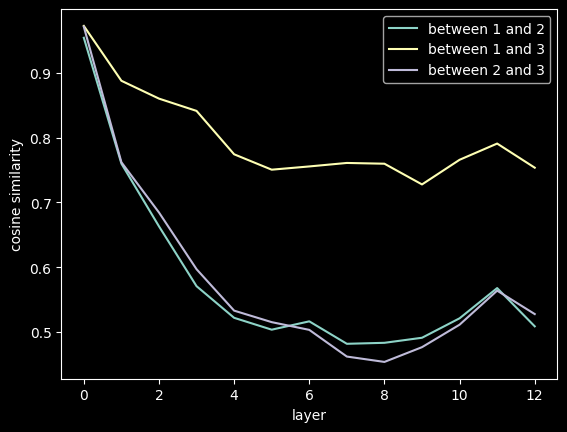

In [7]:
text1 = "We will rob a bank next week!"
text2 = "The children skipped stones by the bank of the river."
text3 = "I put money in the bank."
tokenized = tokenizer([text1, text2, text3], padding=True, return_tensors='pt').to(device)
print(tokenized)

tokens1 = tokenizer.convert_ids_to_tokens(tokenized['input_ids'][0])
tokens2 = tokenizer.convert_ids_to_tokens(tokenized['input_ids'][1])
tokens3 = tokenizer.convert_ids_to_tokens(tokenized['input_ids'][2])
print(tokens1)
print(tokens2)
print(tokens3)

tokens_ids_of_interest = [5, 7, 6]
print(tokens1[tokens_ids_of_interest[0]])
print(tokens2[tokens_ids_of_interest[1]])
print(tokens3[tokens_ids_of_interest[2]])

model_outputs = model(**tokenized, output_hidden_states=True)
plot_evolving_similarities(model_outputs['hidden_states'], tokens_ids_of_interest)

<a name='e1'></a>
### Exercise 1 Evolution of embeddings

- Discuss the plot above. Are the plots showing what you expected to see?
- Take a look at the similarity between the word "bank" in the first layer (layer index 0). This corresponds to the embedding layer of BERT. It is exactly `1` for sentences 1 and 3 but only close to `1` (but not exactly) for the two other pairs. Why is that?
- Plot and analyze the similarities between words "nice", "bad", and "lovely" in the sentences "The weather is nice today.", "The weather is bad today.", and "The weather is lovely today.". Remember to correctly set the indices of the words in each sentence. Comment on the results. Are the plots showing what you expected to see?
- Try a different sets (at least 2 more sets) of sentences and comment on the results.

{'input_ids': tensor([[ 101, 1996, 4633, 2003, 3835, 2651, 1012,  102],
        [ 101, 1996, 4633, 2003, 2919, 2651, 1012,  102],
        [ 101, 1996, 4633, 2003, 8403, 2651, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1]])}
['[CLS]', 'the', 'weather', 'is', 'nice', 'today', '.', '[SEP]']
['[CLS]', 'the', 'weather', 'is', 'bad', 'today', '.', '[SEP]']
['[CLS]', 'the', 'weather', 'is', 'lovely', 'today', '.', '[SEP]']
nice
bad
lovely


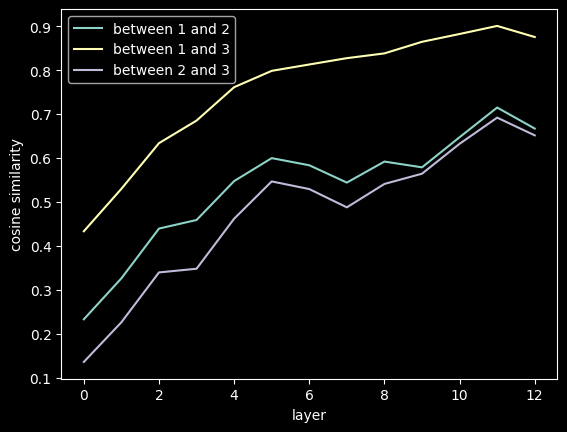

{'input_ids': tensor([[  101, 17095,  2038,  1037,  2502, 15485,  1012,   102,     0],
        [  101, 17095,  2038,  1037,  5437,  2100, 15485,  1012,   102],
        [  101, 17095,  2038,  1037,  2307, 15485,  1012,   102,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0]])}
['[CLS]', 'felipe', 'has', 'a', 'big', 'worm', '.', '[SEP]', '[PAD]']
['[CLS]', 'felipe', 'has', 'a', 'smell', '##y', 'worm', '.', '[SEP]']
['[CLS]', 'felipe', 'has', 'a', 'great', 'worm', '.', '[SEP]', '[PAD]']
big
smell
great


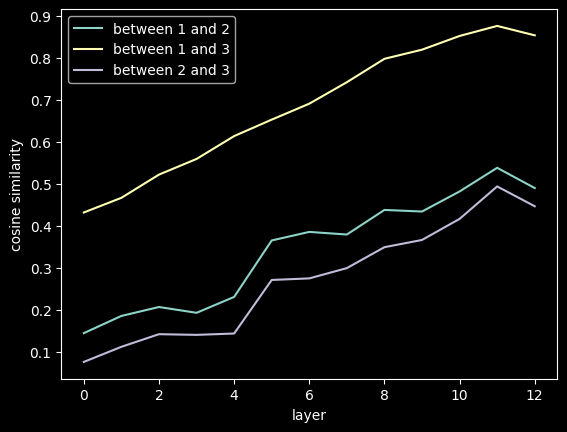

{'input_ids': tensor([[  101,  1996,  2783,  2003,  2205,  2844,  2000,  9880,   102,     0],
        [  101,  1996,  2783,  2465,  2003,  5186, 11771,   102,     0,     0],
        [  101,  2040,  2003,  1996,  2783, 12038,  2088,  3410,  1029,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
['[CLS]', 'the', 'current', 'is', 'too', 'strong', 'to', 'swim', '[SEP]', '[PAD]']
['[CLS]', 'the', 'current', 'class', 'is', 'extremely', 'boring', '[SEP]', '[PAD]', '[PAD]']
['[CLS]', 'who', 'is', 'the', 'current', 'lightweight', 'world', 'champion', '?', '[SEP]']
current
current
current


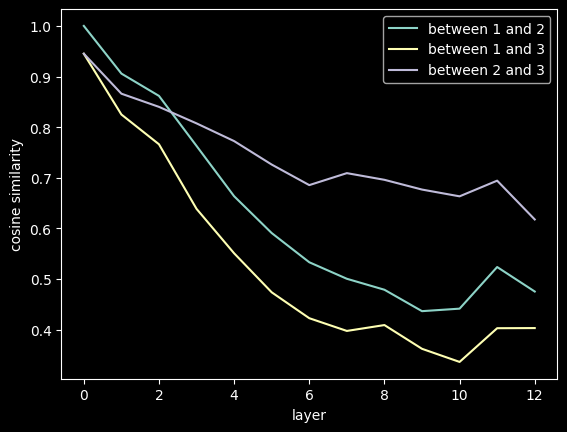

In [25]:
### YOUR CODE HERE
# QUESTION 1.4
text1 = "The weather is nice today."
text2 = "The weather is bad today."
text3 = "The weather is lovely today."
tokenized = tokenizer([text1, text2, text3], padding=True, return_tensors='pt').to(device)
print(tokenized)

tokens1 = tokenizer.convert_ids_to_tokens(tokenized['input_ids'][0])
tokens2 = tokenizer.convert_ids_to_tokens(tokenized['input_ids'][1])
tokens3 = tokenizer.convert_ids_to_tokens(tokenized['input_ids'][2])
print(tokens1)
print(tokens2)
print(tokens3)

tokens_ids_of_interest = [4, 4, 4]
print(tokens1[tokens_ids_of_interest[0]])
print(tokens2[tokens_ids_of_interest[1]])
print(tokens3[tokens_ids_of_interest[2]])

model_outputs = model(**tokenized, output_hidden_states=True)
plot_evolving_similarities(model_outputs['hidden_states'], tokens_ids_of_interest)

# QUESTION 1.5
text1 = "Felipe has a big worm."
text2 = "Felipe has a smelly worm."
text3 = "Felipe has a great worm."
tokenized = tokenizer([text1, text2, text3], padding=True, return_tensors='pt').to(device)
print(tokenized)

tokens1 = tokenizer.convert_ids_to_tokens(tokenized['input_ids'][0])
tokens2 = tokenizer.convert_ids_to_tokens(tokenized['input_ids'][1])
tokens3 = tokenizer.convert_ids_to_tokens(tokenized['input_ids'][2])
print(tokens1)
print(tokens2)
print(tokens3)

tokens_ids_of_interest = [4, 4, 4]
print(tokens1[tokens_ids_of_interest[0]])
print(tokens2[tokens_ids_of_interest[1]])
print(tokens3[tokens_ids_of_interest[2]])

model_outputs = model(**tokenized, output_hidden_states=True)
plot_evolving_similarities(model_outputs['hidden_states'], tokens_ids_of_interest)

# QUESTION 1.5
text1 = "The current is too strong to swim"
text2 = "The current class is extremely boring"
text3 = "Who is the current lightweight world champion?"
tokenized = tokenizer([text1, text2, text3], padding=True, return_tensors='pt').to(device)
print(tokenized)

tokens1 = tokenizer.convert_ids_to_tokens(tokenized['input_ids'][0])
tokens2 = tokenizer.convert_ids_to_tokens(tokenized['input_ids'][1])
tokens3 = tokenizer.convert_ids_to_tokens(tokenized['input_ids'][2])
print(tokens1)
print(tokens2)
print(tokens3)

tokens_ids_of_interest = [2, 2, 4]
print(tokens1[tokens_ids_of_interest[0]])
print(tokens2[tokens_ids_of_interest[1]])
print(tokens3[tokens_ids_of_interest[2]])

model_outputs = model(**tokenized, output_hidden_states=True)
plot_evolving_similarities(model_outputs['hidden_states'], tokens_ids_of_interest)
### YOUR CODE ENDS HERE

--- YOUR ANSWERS HERE

1. the plot makes sense because if we examine the sentences, we realize that sentences 1 and 3 have the same 'bank' meaning, that of a money bank. While sentence 2 has a different meaning from the other two, that of a river bank. This is reflected in the graph because we can observe that by the final layer the cosine similarity between sentence 1 and 3 is high while the other cosine similarities are low. The graph also describes the process by which this happens because we can see that in the first BERT layer all cosine similarities start out the same, and they changethroughout the layers as the BERT model process them.
2. The embedding layer takes into account the vector embedding of the word 'bank' (from the model's vocabulary) and also the positional embedding (vector representing each position in a sentence). Sentence 1 has'bank' in position 4 and sentence 3 has 'bank' in position 5, which are very similar and probably round up to 1. Whereas sentence 2 has 'bank' at position 7, which probably makes enough of a difference to make the embedding close to 1 but not quite.
3. the plot behaves as expected. Unlike th eprevious plot, all cosine similarities don't start off at near one because they all have different words, with different vector embeddings, and different positional embeddings. as the BERT layers increase, the cosine similarity between 1 and 3 increaces a lot, as expected, since they have similar meaning (positive). while the other cosine similarities between the other two pairs remains similar and lower since they have opposite meanings (positive and negative).
4. the results for th plots behave as expected. for the first example, 'big' and 'great' have the highest cosine similarity. For the second example, the cosine similarity between 1 and 2 starts out at 1 because they both have the same word at the same position, eventhough they have different meanings. As the layers increase, the cosine similarity between 2 and 3 grows as expected since they both have the same meaning, while the other two pairs drops as they have different meanings os 'current'

### Sentence-level embeddings

In this section we will look at the sentence embeddings of BERT. We will experiment with the CLS token and averaging the tokens in the sentence.

First, implement the functions to obtain the embeddings from the model's outputs. They should be very similar to the ones you implemented in the previous lab. But, notice the `layer` parameter - this time. Previously, we were interested in the representations returned by the last layer of the model. This time, we want to specify the layer.

<a name='e2'></a>
#### Exercise 2: BERT sentence embeddings by the CLS token

Implement the following function which calculates the sentence embeddings based on the model output (passed to the function as a parameter). It should take the embedding of the CLS token of the specified layer (by the `layer` parameter).

In [ ]:
def calculate_cls_embeddings(input_batch, model_output, layer=-1):
    """
    Calculates the sentence embeddings of a batch of sentences as the last-layer representation of the CLS token.
    Args:
        input_batch: tokenized batch of sentences (as returned by the tokenizer), contains `input_ids`, `token_type_ids`, and `attention_mask` tensors
        model_output: the output of the model given the `input_batch`, contains `last_hidden_state`, `pooler_output`, `hidden_states` tensors
        layer: specifies the layer of the hidden states that are used to calculate sentence embedding

    Returns: tensor of the hidden states of the CLS token (from the last layer) for each example in the batch

    """

    ### YOUR CODE HERE
  # example


    ### YOUR CODE ENDS HERE

    return sentence_embeddings

<a name='e3'></a>
### Exercise 3 Implement sentence embeddings

Implement the following function. It will receive the batched input to the model and its output. Calculate the mean embedding of the tokens in each sentence. In particular, get `attention_mask` from the `input_batch` and `hidden_states` from `model_output`, and calculate the mean of the hidden states.

Pay attention to the padded tokens (indicated by the attention mask from the input). The function should take the embedding of the CLS token of the specified layer (by the `layer` parameter). You should ignore the special tokens `[CLS]` and `[SEP]`.

In [ ]:
def calculate_sentence_embeddings(input_batch, model_output, layer=-1):
    """
    Calculates the sentence embeddings of a batch of sentences as a mean of token representations.
    The representations are taken from the layer of the index provided as a `layer` parameter.
    Args:
        input_batch: tokenized batch of sentences (as returned by the tokenizer), contains `input_ids`, `token_type_ids`, and `attention_mask` tensors
        model_output: the output of the model given the `input_batch`, contains `last_hidden_state`, `pooler_output`, `hidden_states` tensors
        layer: specifies the layer of the hidden states that are used to calculate sentence embedding

    Returns: tensor of the averaged hidden states (from the specified layer) for each example in the batch

    """

    ### YOUR CODE HERE



    ### YOUR CODE ENDS HERE


    return sentence_embeddings

The following function will plot the evolution of cosine similarities between sentence embeddings based on representations of different layers of the model.

Notice that it will receive a function that is used to calculate the embeddings (that are the functions we implemented above).

In [ ]:
def plot_evolving_sentence_similarities(input_batch, model_outputs, sentence_embeddings_fn):
    num_layers = len(model_outputs['hidden_states'])
    num_sentences = input_batch['input_ids'].shape[0]
    sentence_combinations = tuple(combinations(range(num_sentences), 2))
    similarities = [[] for _ in range(len(sentence_combinations))]

    for layer in range(num_layers):
        sentence_embeddings = sentence_embeddings_fn(input_batch, model_outputs, layer)
        for i, (sent1, sent2) in enumerate(sentence_combinations):
            embedding1 = sentence_embeddings[sent1]
            embedding2 = sentence_embeddings[sent2]
            cosine_similarity = torch.nn.functional.cosine_similarity(embedding1, embedding2, dim=0)
            similarities[i].append(cosine_similarity.detach().cpu().numpy())

    for i, (sent1, sent2) in enumerate(sentence_combinations):
        plt.plot(range(num_layers), similarities[i], label=f'between {sent1 + 1} and {sent2 + 1}')

    plt.xlabel('layer')
    plt.ylabel('cosine similarity')
    plt.legend()
    plt.show()

Let's examine the cosine similarities of some sentences with the word "bank".

In [ ]:
text1 = "We will rob a bank next week!"
text2 = "Let's put our savings into a bank account."
text3 = "We will steal some money from the bank."

tokenized = tokenizer([text1, text2, text3], padding=True, return_tensors='pt').to(device)

model_outputs = model(**tokenized, output_hidden_states=True)
plot_evolving_sentence_similarities(tokenized, model_outputs, calculate_cls_embeddings)

In [ ]:
text1 = "We will rob a bank next week!"
text2 = "Let's put our savings into a bank account."
text3 = "We will steal some money from the bank."

tokenized = tokenizer([text1, text2, text3], padding=True, return_tensors='pt').to(device)

model_outputs = model(**tokenized, output_hidden_states=True)
plot_evolving_sentence_similarities(tokenized, model_outputs, calculate_sentence_embeddings)

<a name='e4'></a>
### Exercise 4: Try different sentences

Try out your sentence embeddings on at least two different sets of sentences. Inspect the results in terms of the different layers. Comment on the results. Are they expected?

In [ ]:
### YOUR CODE HERE


### YOUR CODE ENDS HERE

--- YOUR ANSWERS HERE

## Loading the Dataset

We will work with "The Multi-Genre Natural Language Inference Corpus" (MNLI). It is a part of GLUE evaluation dataset [https://huggingface.co/datasets/nyu-mll/glue](https://huggingface.co/datasets/nyu-mll/glue). From the datacard:

"The Multi-Genre Natural Language Inference Corpus is a crowdsourced collection of sentence pairs with textual entailment annotations. Given a premise sentence and a hypothesis sentence, the task is to predict whether the premise entails the hypothesis (entailment), contradicts the hypothesis (contradiction), or neither (neutral)."

The labels are as follows:
- 0 - entailment,
- 1 - neutral,
- 2 - contradiction.
To use the binary classification, we will drop the `neutral` label later.

The train split is quite large, so we will limit the number of examples in the `train` subset to `20,000`. The `validation_matched` are split consist of the in-domain examples. In this case, "in-domain" means that the sources of the examples (genres, like fiction, telephone, etc.) are the same as in the training dataset. Note that the dataset contains `test_matched` subset, but it is not labeled (the labels are not public). For this reason, we will use the `validation` split to test our models and sample examples for validation from the `train` subset.

In [ ]:
dataset = datasets.load_dataset("nyu-mll/glue", "mnli", split=['train[:20000]', 'validation_matched'])
print(dataset)

Notice that the dataset has been loaded as a list of datasets. Let's extract the `validation` subset and put them into one `DatasetDict` object.

In [ ]:
train_valid_split = dataset[0].train_test_split(5000)
dataset = datasets.DatasetDict({
    'train': train_valid_split['train'],
    'validation': train_valid_split['test'],
    'test': dataset[1].shuffle(),
})
print(dataset)

We can print several examples from the `train` dataset:

In [ ]:
for i in range(10):
    print('idx:', dataset['train'][i]['idx'])
    print('label:', dataset['train'][i]['label'])
    print('premise:', dataset['train'][i]['premise'])
    print('hypothesis:', dataset['train'][i]['hypothesis'])
    print()

To make our lives simpler, we will drop the `neutral` label. We will use the `filter()` method of the dataset. Next, we will transform label `2` into label `1` using the `map()` method.

In [ ]:
dataset = dataset.filter(lambda example: example['label'] != 1, desc='Filter')
dataset = dataset.map(lambda example: {'label': 1 if example['label'] == 2 else 0}, desc='Relabel')
print(dataset)

Let's extract the labels from the dataset. We will use them to train and evaluate our classifiers.

In [ ]:
y_train = dataset['train']['label']
print(y_train)
y_valid = dataset['validation']['label']
print(y_valid)

<a name='e5'></a>
#### Exercise 5: Cleaning the text

In this exercise you should clean the text in the dataset. This is the same step we saw in the previous labs.

If you think this step is not necessary in this use case, you can skip this step, but make sure to justify your decision.

In [ ]:
def clean(text):
    """
    Cleans the text
    Args:
        text: a string that will be cleaned

    Returns: the cleaned text

    """

    # Empty text
    if text == '':
        return text

    ### YOUR CODE HERE



    ### YOUR CODE ENDS HERE

    return text


def clean_example(example):
    """
    Applies the clean() function to the example from the Dataset
    Args:
        example: an example from the Dataset

    Returns: update example with cleaned 'text' column

    """
    example['premise'] = clean(example['premise'])
    example['hypothesis'] = clean(example['hypothesis'])
    return example


dataset = dataset.map(clean_example, desc="Cleaning")
print(dataset)

## Baseline: Bag-of-Words or Word2Vec Classifier

In this section, you will implement one of the classifiers you used in the previous lab: Bag-of-Words or Word2Vec (your choice).

<a name='e6'></a>
#### Exercise 6: Implementing a baseline

Implement the BOW or word2vec (e.g., Glove). Train a classifier (e.g., logistic regression) on top of your chosen representation. Note, that the examples consist of two sentences: `premise` and `hypothesis`. Think about how to handle this case. In the report, make sure to include the explanation and reasoning of your decisions. Use the `validation` split for tuning any parameters, and `test` split for final results.

In [ ]:
#### YOUR CODE HERE



#### YOUR CODE ENDS HERE

## BERT Classifier

In this section you will explore different ways we can use the BERT model for classification. We will start simple, with the classification based on the CLS token and averaging the token embeddings (very similar to the previous lab).

BERT was trained to accept two sentences, and we can make use of that. Just pass the two sentences to the tokenizer:

In [ ]:
tokenized = tokenizer('First sentence.', 'Second sentence.')
print(tokenized)
print(tokenizer.convert_ids_to_tokens(tokenized['input_ids']))

Notice the `token_type_ids` element that encodes whether the token belongs to the first or second sentence.

This also works with batches:

In [ ]:
tokenized = tokenizer([['text 1 1', 'text 1 2'], ['text 2 1', 'text 2 2'], ['text 3 1', 'text 3 2']], padding=True, return_tensors='pt').to(device)
print(tokenized)

<a name='e7'></a>
#### Exercise 7: BERT CLS token

Implement and test classification based on the CLS token in BERT.

In [ ]:
#### YOUR CODE HERE



#### YOUR CODE ENDS HERE

--- YOUR ANSWERS HERE

<a name='e8'></a>
#### Exercise 8: BERT mean token embeddings

Implement and test classification based on the mean token embeddings from BERT. How will you handle the fact that the classification is based on two sentences?

In [ ]:
#### YOUR CODE HERE



#### YOUR CODE ENDS HERE

--- YOUR ANSWERS HERE

<a name='e9'></a>
#### Exercise 9: Finding the best layer for representation

So far, we have used only the representations of the last layer for classification. But, lower layers could also contain information useful for our task. In this exercise, you will perform experiments to find out which layer is the most useful for our classifier. Adapt the previous exercises to obtain the CLS and averaged tokens representations from different layers. Train classifiers based on those representations. Discuss the results. Is the last layer indeed the best for classification? Remember to use the `validation` subset at this point, and the `test` subset for the final results.

In [ ]:
#### YOUR CODE HERE



#### YOUR CODE ENDS HERE

--- YOUR ANSWERS HERE


## Testing all methods

As in previous lab, you will evaluate the methods

--- YOUR ANSWERS HERE

<a name='e10'></a>
#### Exercise 10: Evaluating methods on the test set

Test the models you implemented on the test subset:
- BOW or word2vec,
- CLS token from BERT (last layer),
- mean of tokens from BERT (last layer),
- CLS token from BERT (best non-last layer),
- mean of tokens from BERT (best non-last layer).

Evaluate the performance using the metric you found the best in the previous lab. Make sure to discuss the results. Which model performed best? Is this what you expected?

In [ ]:
#### YOUR CODE HERE


### YOUR CODE ENDS HERE

--- YOUR ANSWERS HERE